# 贝叶斯回归 - 介绍 (第一部分)

回归是机器学习中最常见和最基本的监督学习任务之一。假设我们得到了一个数据集 $\mathcal{D}$ ，其形式为

$$
 \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N
$$

线性回归的目标是为数据拟合一个如下形式的函数：

$$
y = w X + b + \epsilon 
$$

其中 $w$ 和 $b$ 是可学习的参数， $\epsilon$ 表示观测噪声。具体说来在 $w$ 是权重矩阵，而 $b$ 是偏差向量。

在本教程中，我们将首先在 PyTorch 中实现线性回归，并学习参数 $w$ 和 $b$ 的点估计值。然后，我们将了解如何通过 Pyro 实现贝叶斯回归，来将不确定性纳入估计中。此外，还将学习如何使用 Pyro 的工具函数进行预测，并使用`TorchScript`  提供模型服务。

## 1 基本设置

首先导入需要的模块：

In [1]:
%reset -s -f

In [3]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

## 2 数据集 

以下示例改编自 [1]。我们想探索由地形崎岖度指数衡量的某个国家地形异质性与其人均 GDP 之间的关系。特别是，作者在[2]中指出，地形崎岖或地理条件差在非洲以外的地区确实和经济表现较差有关，但在非洲国家却与收入有着相反的关系。让我们看看数据并审查这种关系是否是真的。我们将重点引入数据集中的三个特征：

  - `rugged`: 经过量化的地形崎岖度指数
  - `cont_africa`: 该国家是否在非洲
  - `rgdppc_2000`: 2000 年的实际人均国内生产总值
  
响应变量 GDP 是高度偏斜的，因此我们将对它进行对数变换。

In [5]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

/home/xishansnow/miniconda3/envs/pyro/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/xishansnow/miniconda3/envs/pyro/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


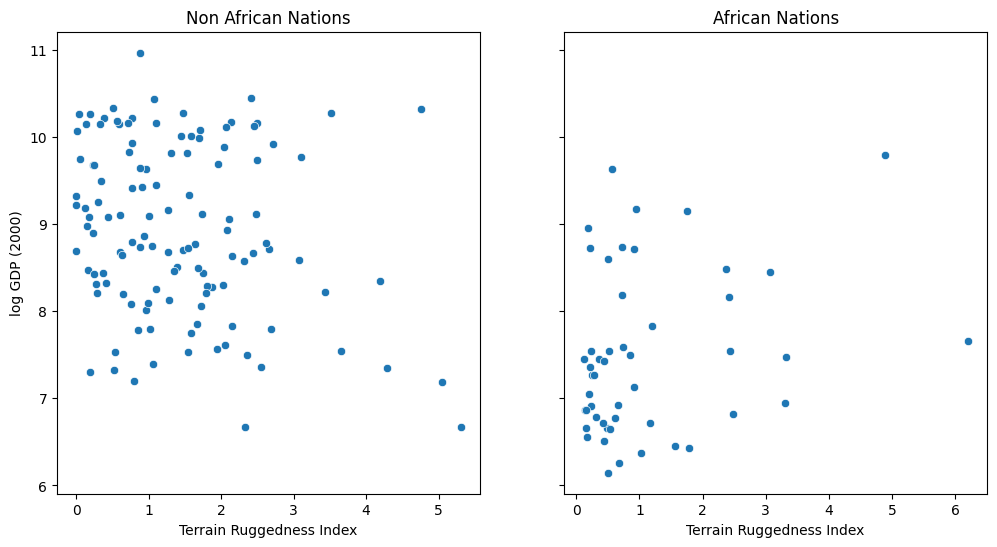

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], 
            non_african_nations["rgdppc_2000"], 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"], 
                african_nations["rgdppc_2000"], 
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## 3  Pytorch  和 Pyro 中的线性回归

我们想根据数据集的两个特征（ `cont_africa` 和 `rugged` ）来预测一个国家的对数人均 GDP（`rgdppc_2000`）。我们将创建一个名为 `PyroModule[nn.Linear]` 的普通类，它是 [PyroModule](http://docs.pyro.ai/en/dev/nn.html#module-pyro.nn.module) 和 `torch.nn.Linear`  的子类。 `PyroModule` 与 PyTorch 的 `nn.Module` 非常相似，但额外支持 [Pyro 元语](http://docs.pyro.ai/en/dev/primitives.html#primitives) 作为可以被 [Pyro 效果处理程序](http://pyro.ai/examples/effect_handlers.html) 修改的属性。

一些注意事项：

- PyTorch 模块中的可学习参数是 `nn.Parameter` 的实例，在本例中表现为为 `nn.Linear` 类的两个参数 `weight` 和 `bias` 。当在 `PyroModule` 中声明为属性时，这些会自动注册到 Pyro 的参数存储库中。虽然该模型不需要在优化过程中约束这些参数的值，但我们可以在 `PyroModule` 中随时使用 [PyroParam 语句](http://docs.pyro.ai/en/dev/nn.html#pyro.nn.module.PyroParam) 轻松访问它们。

- 虽然 `PyroModule[nn.Linear]` 的 `forward` 方法继承自 `nn.Linear`，但它也很容易被覆盖。例如在 `logistic 回归` 情况下，我们对线性预测器应用 `sigmoid` 变换。

In [7]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

##  4 使用 PyTorch 的优化器进行训练

除了 `rugged` 和 `cont_africa` 两个特征之外，我们在模型中还包含了一个交互项，这让我们可以分别模拟地形崎岖度对非洲内外国家 GDP 的影响。

我们使用均方误差 (MSE) 作为损失函数，使用来自 `torch.optim` 模块的 `Adam` 作为优化器。我们的目标是优化模型的参数（ 即网络权重 $w$ 和偏差参数 $b$ ），它们对应于回归系数和截距。

In [8]:
# dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

            
# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7847
[iteration 0100] loss: 1616.1371
[iteration 0150] loss: 1109.4115
[iteration 0200] loss: 833.7546
[iteration 0250] loss: 637.5823
[iteration 0300] loss: 488.2653
[iteration 0350] loss: 376.4651
[iteration 0400] loss: 296.0484
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9386
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3493
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

让我们绘制下模型的回归拟合效果，并将非洲内外的国家区分开。

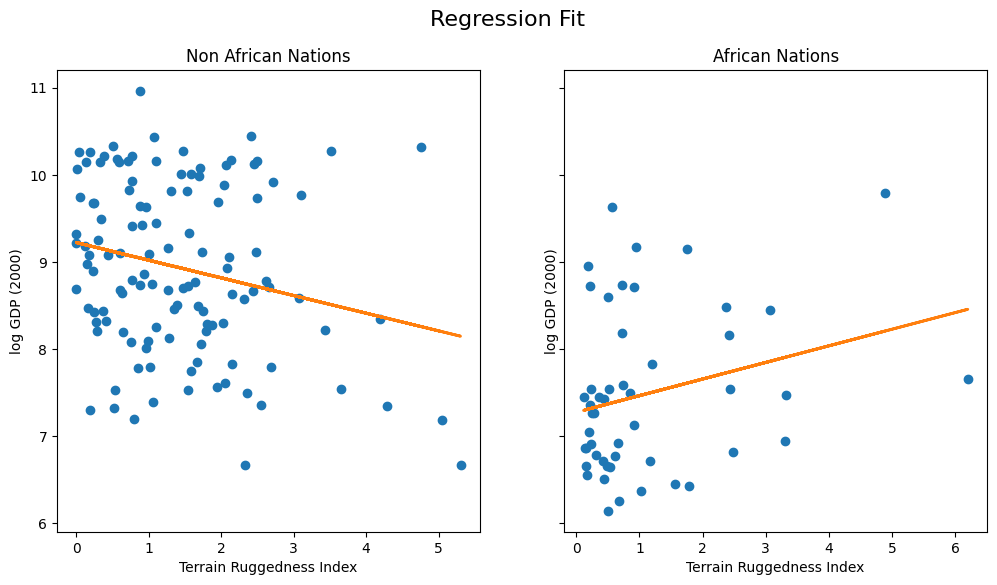

In [9]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

我们注意到，地形崎岖度与非洲以外国家的 GDP 成反比关系，但它对非洲国家的 GDP 却产生了积极影响。然而，目前尚不清楚这种趋势的强度。特别的，我们想了解回归拟合将如何因参数的不确定性而变化。为解决此问题，将为线性回归构建一个简单的贝叶斯模型。 [贝叶斯建模](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) 为推断模型的不确定性提供了一个系统的框架。我们将学习与观测数据一致的参数分布，而不是仅仅学习该参数的点估计。

## 5 使用 Pyro 的随机变分推断做贝叶斯回归

### 5.1 模型

为了使线性回归贝叶斯化，需要在参数 $w$ 和 $b$ 上放置先验。这些分布代表了我们对 $w$ 和 $b$ 合理值的先验信念（在观测到任何数据之前）。

如前所述，使用 `PyroModule` 为线性回归制作贝叶斯模型非常直观。请注意以下事项：

- `BayesianRegression` 模块在内部使用相同的 `PyroModule[nn.Linear]` 模块。但是我们用 `PyroSample` 语句替换了此模块的 `weight` 和 `bias`。这些语句允许我们在“ `weight` 和 `bias`参数上放置先验，而不是将其视为固定的可学习参数。对于 `bias` 分量，需要设置了一个合理宽度的先验，因为它可能远远大于 0。 

- `BayesianRegression.forward` 方法指定了生成过程。我们通过调用  `linear`  模块来生成响应的平均值（该模块从先验中对 `weight` 和 `bias` 参数进行采样，并返回一个平均响应值）。最后，我们使用 `pyro.sample` 语句的 `obs` 参数，将条件设置为含观测噪声 `sigma` 的观测数据 `y_data` 。该模型返回由变量 `mean` 给出的回归线。

In [10]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

### 5.2 引导与自动引导（ AutoGuide ） 

为了进行推断（即学习未观测到的参数的后验分布），我们将使用随机变分推断 (SVI)。引导（`guide`）确定了一个分布族，`SVI` 旨在从这个族中找到一个近似后验分布，它与真实后验具有最小的 KL 散度。

用户可以在 Pyro 中编写任意灵活的自定义`引导`，但在本教程中，将先限于 Pyro 的[自动引导](http://docs.pyro.ai/en/dev/infer.autoguide.html)。在[下一个教程](002_bayesian_regression_ii.ipynb) 中，才会探索如何手动编写引导。

首先，将使用 `AutoDiagonalNormal` 作为`引导`，该`引导`将模型中不可观测变量（参数）的分布建模为具有对角协方差的高斯分布，即它假设隐变量之间没有相关性（这是一种非常强的建模假设，我们将见[第二部分](002_bayesian_regression_ii.ipynb) 中见到它)。在程序底层，这定义了一个 `引导`，它使用 `正态` 分布，其可学习参数对应于模型中的每个 `sample` 语句。例如在我们的例子中，这个分布的大小应该为 `(5,)`，对应于每个项的 $3$ 个回归系数 、$1$ 个截距项和 $1$ 个噪声参数 `sigma`。

Autoguide 还支持使用 `AutoDelta` 学习 MAP 估计或使用 `AutoGuideList` 编写`引导`。有关更多信息，请参阅 [相关说明文档](http://docs.pyro.ai/en/dev/infer.autoguide.html)。

In [11]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

### 5.3 优化证据下界 ELBO

我们将使用随机变分推断。就像在非贝叶斯线性回归模型中一样，训练的每次迭代过程都将采取一次梯度步骤，不同之处在于，现在我们将通过给 `SVI` 传递 `Trace_ELBO`对象的方式，来使用证据下界 (ELBO) 作为目标函数，而不是通过使用 MSE 损失。

In [12]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

请注意，我们使用 Pyro 的 `optim` 模块中的 `Adam` 优化器，而不是之前的 `torch.optim` 模块。这里的 `Adam` 是一个围绕 `torch.optim.Adam` 的瘦包装器（请参见 [此处](svi_part_i.ipynb#Optimizers)）。 `pyro.optim` 中的优化器用于优化和更新 Pyro 参数存储库中的参数值。特别是，我们不需要将待学习参数传递给优化器，因为这由`引导` 代码来确定，并且会自动在 `SVI` 类的后端代码中自动进行。要执行 ELBO 梯度步骤，只需调用 SVI 的 `step` 方法即可。我们传递给 `SVI.step` 的数据参数将通过管道同时传递给 `model()` 和 `guide()`。

完整的训练循环如下：

In [13]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5269
[iteration 0201] loss: 3.2377
[iteration 0301] loss: 3.0867
[iteration 0401] loss: 2.6374
[iteration 0501] loss: 2.0617
[iteration 0601] loss: 1.4856
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4939
[iteration 1101] loss: 1.4989
[iteration 1201] loss: 1.4937
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


我们可以从 Pyro 的参数存储库中获取优化后的参数值。

In [14]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3790,  9.1824])
AutoDiagonalNormal.scale tensor([0.0552, 0.1143, 0.0387, 0.0769, 0.0700])


如您所见，现在已经对参数进行了不确定性估计（`AutoDiagonalNormal.scale`），而不仅仅是点估计。请注意，Autoguide 将隐变量打包成了一个单一张量，在此情况下，模型中采样的每个变量对应其中一个元素。 `loc` 和 `scale` 参数的大小都是 `(5,)`，正如我们之前所说的，模型中的每个隐变量都有一个大小。

为了更清楚地查看隐参数的分布，可以使用 `AutoDiagonalNormal.quantiles` 方法，该方法将从 autoguide 中解包出隐变量的样本，并自动将建立约束（例如变量 `sigma` 必须位于 `(0, 10)`)。可以看出，参数的中位数与第一个模型中获得的最大似然点估计值非常接近。

In [15]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9327, 0.9647, 0.9976]),
 'linear.weight': tensor([[[-1.8868, -0.1952,  0.3272]],
 
         [[-1.8097, -0.1691,  0.3790]],
 
         [[-1.7325, -0.1430,  0.4309]]]),
 'linear.bias': tensor([[9.1351],
         [9.1824],
         [9.2296]])}

## 6 用 Pyro 做模型评估

为了评估模型，我们将生成一些预测样本并查看后验。为此，可以使用 [Predictive 工具类](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive)  。 

- 我们从训练好的模型中生成 800 个样本。在内部，这首先在 `guide` 中生成未观测点处的样本，然后基于 `guide` 抽取的样本前向运行模型。请参阅 [Model Serving](#Model-Serving-via-TorchScript) 部分以深入了解 `Predictive` 类的工作原理。 
- 在 `return_sites` 中，我们既指定了输出结果（"obs" 点），同时也指定了模型的返回值（`"_RETURN"`）。此外，我们还想捕获回归系数（由 `linear.weight` 给出）以供进一步分析。 
- 其余代码仅用于绘制模型中两个变量的 90% CI。

In [16]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, 
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [17]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

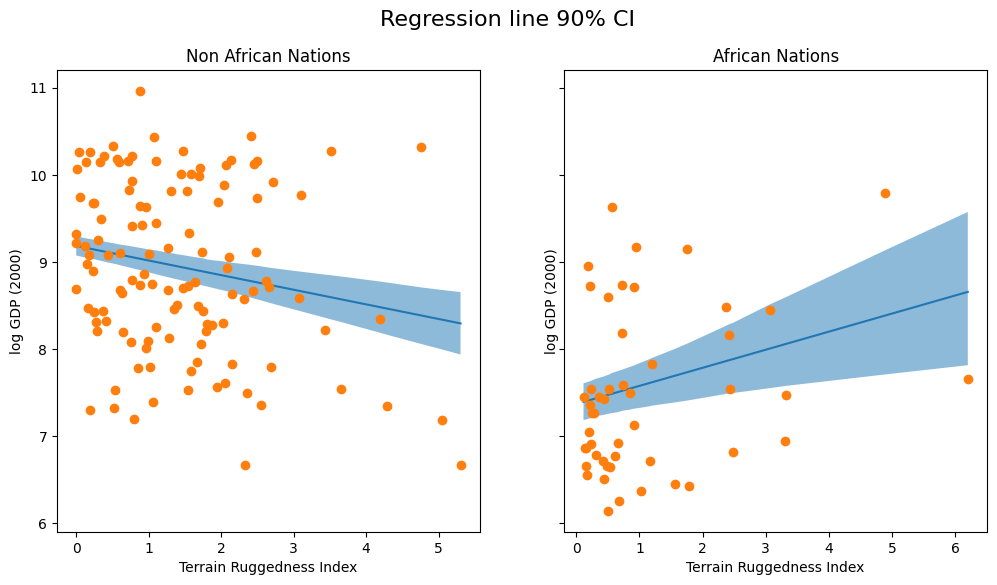

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"], 
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

上图显示了我们对回归线估计的不确定性，以及均值附近的 90% CI。可以看到大多数数据点实际上位于 90% CI 之外，这是意料之中的，因为我们没有绘制将受 sigma 影响的结果变量！让我们接下来这样做。

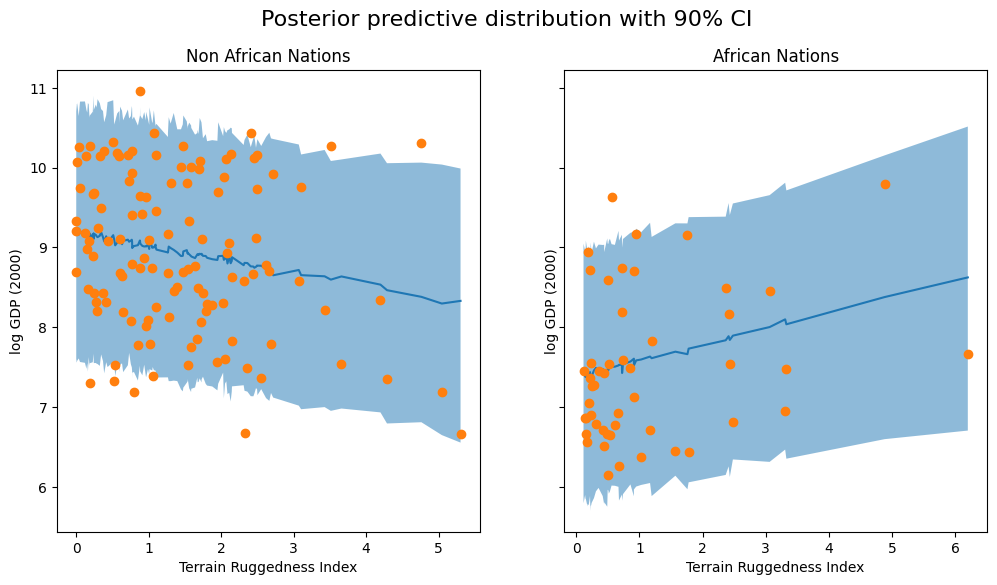

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"], 
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"], 
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"], 
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

模型的结果和 90% CI 占实际观测数据的大多数，即能够解释观测数据。进行此类后验预测检查来查看模型预测是否有效通常是一个好主意。

最后，让我们重新审视之前的问题，即地形崎岖度与 GDP 之间的关系到底有多稳健，它其实非常依赖于模型参数估计中的不确定性。为此，我们绘制了给定非洲内外国家地形崎岖度时的对数 GDP 斜率分布图。如下所示，非洲国家的概率质量主要集中在正值区域，其他国家的反之亦然，这进一步证实了原始假设。

/home/xishansnow/miniconda3/envs/pyro/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/xishansnow/miniconda3/envs/pyro/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


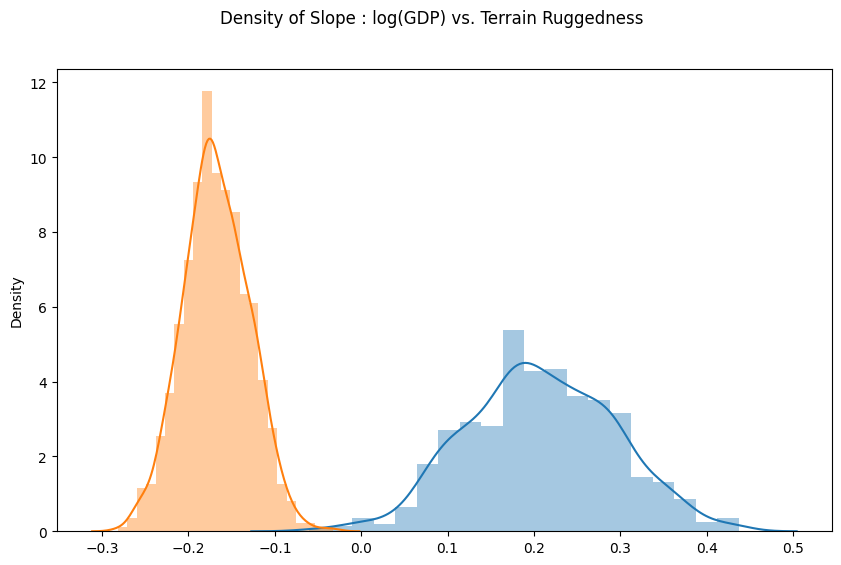

In [20]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## 7 用 TorchScript 提供模型服务

最后，注意`model`、`guide` 和 `Predictive` 工具类都是 `torch.nn.Module` 的实例，可以序列化为 [TorchScript](https://pytorch.org/docs/stable/jit.html) 。

在这里，我们展示了如何将 Pyro 模型转换为 [torch.jit.ModuleScript](https://pytorch.org/docs/stable/jit.html#torch.jit.ScriptModule) ，以作为一个没有 Python 运行环境的 C++ 执行程序提供服务。

为此，我们会使用 [Pyro 的效果处理库](http://pyro.ai/examples/effect_handlers.html) 重写简单版本的  `Predictive` 工具类。这需要：

- `trace` poutine：从 `模型/引导` 代码的运行中捕获执行的迹。
- `replay` poutine：将`模型`中的样本条件设置为在 `引导` 的迹中的样本集。

In [21]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings


class Predict(torch.nn.Module):
    def __init__(self, model, guide):
        super().__init__()
        self.model = model
        self.guide = guide
        
    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]['value']
        return tuple(v for _, v in sorted(samples.items()))

predict_fn = Predict(model, guide)
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

我们使用 [torch.jit.trace_module](https://pytorch.org/docs/stable/jit.html#torch.jit.trace_module) 追踪这个模块的 `forward` 方法，并使用 [torch.jit.save](https://pytorch.org/docs/stable/jit.html#torch.jit.save) 保存追踪情况。被保存的内容 `reg_predict.pt` 可以使用 PyTorch 的 C++ API `torch::jit::load(filename)` 实施加载，或者使用如下的 Python API。

In [22]:
torch.jit.save(predict_module, '/tmp/reg_predict.pt')
pred_loaded = torch.jit.load('/tmp/reg_predict.pt')
pred_loaded(x_data)

(tensor([9.2164]),
 tensor([[-1.6610, -0.1498,  0.4282]]),
 tensor([ 7.5952,  8.2472,  9.3863,  9.2589,  9.0538,  9.3914,  8.6763,  9.3774,
          9.5471,  9.6144, 10.3520,  8.5453,  5.4010,  8.4600,  9.6217,  9.7772,
          7.1957,  7.2580,  8.9158,  9.0874,  8.3729,  8.7902,  9.3166,  8.8156,
          7.4434,  9.9980,  8.6907,  9.2914, 10.1375,  7.7619, 10.1916,  7.4755,
          6.3474,  7.7584,  9.1307,  6.0795,  8.5640,  7.8485,  9.2827,  9.0762,
          7.9251, 10.9224,  8.0004, 10.1797,  5.3612,  8.1173,  8.0586,  8.5098,
          6.8656,  8.6764,  7.8926,  9.5232, 10.1267, 10.2660,  7.8884,  8.9193,
         10.2864,  7.0823,  8.2370,  8.3088,  7.8409,  8.4892,  8.0106,  7.6814,
          8.7496,  9.3549,  9.9685, 10.4802,  8.5175,  7.1678, 10.8803,  7.4918,
          8.7087,  9.2416,  9.2359,  9.7906,  8.4933,  7.8896,  9.5337,  9.6571,
          9.6602,  9.9853,  6.7416,  8.1719, 10.0645, 10.0816,  8.4501,  9.2587,
          8.4487,  7.7514,  6.8496,  9.2207,  8.98

让我们通过从加载的数据内容中生成样本并重新生成之前的图，来检查 `Predict` 模块是否确实被正确序列化了。

/home/xishansnow/miniconda3/envs/pyro/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/xishansnow/miniconda3/envs/pyro/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


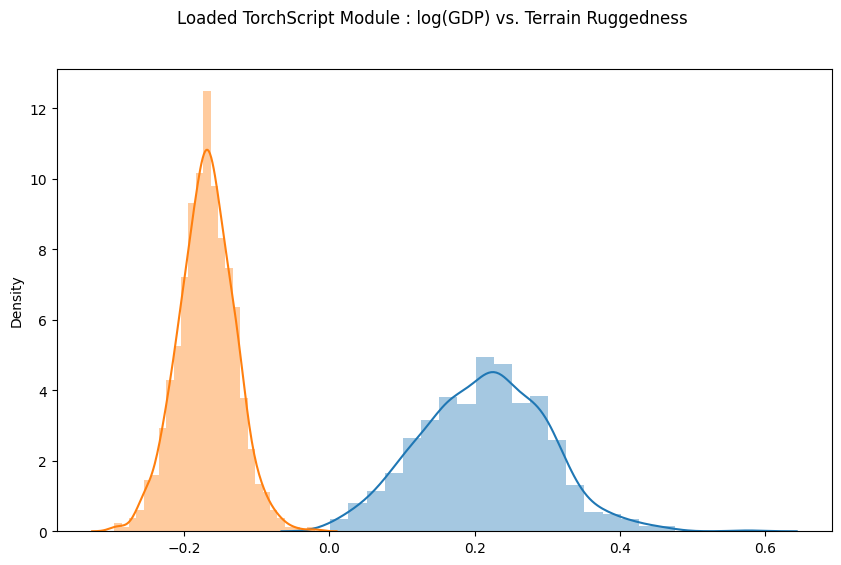

In [23]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])
weight = torch.stack(weight).detach()
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");

在下一节中，我们将研究如何编写变分推断的引导函数，并将结果与 HMC 推断进行比较。

## 参考文献
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012